In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Data Load & Pre-processing

In [2]:
# input folder
data_root = os.path.join(os.getcwd(),'input')

In [3]:
from data_preprocessing import *

In [4]:
df = load_data_from_local(data_root)
df.head(5)

Meta data size: 9022
c:\Users\pywong\Desktop\PolyU\COMP5434 Big Data Computing\Assignment\COMP5434-Big-Data-Computing\input\subset\subset\document_parses\pdf_json
total json files: 12000


100%|██████████| 8083/8083 [00:28<00:00, 285.12it/s]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pywong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pywong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,doc_num,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,processed_text
0,0,0015cecc2298c3bdb9bda0e0b84b38ebdcca716f,10.1007/s40744-022-00425-0,Coronavirus disease 2019 caused by the severe ...,Systemic inflammation is the hallmark of coron...,"Drosos, Alexandros A.. Pelechas, Eleftherios...",Colchicine Against SARS-CoV-2 Infection: What ...,Rheumatol Ther,Coronavirus disease 2019 caused by the severe ...,en,systemic inflammation is the hallmark of coron...
1,1,0016a5c32e9cea6002cf6f352ecdb5231c7e3194,10.30699/ijp.2020.127312.2387,,Severe acute respiratory syndrome coronavirus ...,"Abdollahi, Alireza. shakoori, Abbas...",Comparison of Patient-collected and Lab Techni...,Iran J Pathol,Severe acute respiratory syndrome coronavirus ...,en,severe acute respiratory syndrome coronavirus ...
2,2,0020e5c796f50e927b96ff0b7ea375b4745261a3,10.1186/s12887-020-02112-x,Background: One major limitation for less inva...,Respiratory Distress Syndrome (RDS) affects 85...,"Chevallier, Marie. Durrmeyer, Xavier...",Propofol versus placebo (with rescue with keta...,BMC Pediatr,Background: One major limitation for less inva...,en,respiratory distress syndrome rds affects 85 o...
3,3,00234390dbc45e3370ac8f80cbd93cec3777ca92,10.1016/j.ajur.2021.03.006,Objective: To identify the impact of COVID-19 ...,The World Health Organization (WHO) has announ...,"Raheem Ali, Abdel. Ghazwani, Yahya...",Impact of COVID-19 on endourology surgical pra...,Asian J Urol,Objective: To identify the impact of COVID-19 ...,en,the world health organization who has announce...
4,4,0025fd87cfaf7953079b618771218b8de6893928,10.3389/fcell.2021.748905,,"The concept of specialized ""membrane microdoma...","Garofalo, Tina. Misasi, Roberta...",Editorial: Targeting Lipid Rafts as a Strategy...,Front Cell Dev Biol,"The concept of specialized ""membrane microdoma...",en,the concept of specialized membrane microdomai...


NLP

# Histogram of year / journal

In [26]:
df['publish_year'] = df['publish_time'].dt.year
start_year = 1970
end_year = 2022

mask = (df['publish_year'] >= start_year) & (df['publish_year'] <= end_year)

df = df.loc[mask]
df.info()

KeyError: 'publish_time'

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.countplot(x='publish_year', data=df, color='lightgreen', edgecolor='red',)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', rotation=88)
plt.title('Publish article between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Histogram of Journal

In [ ]:
a = df.groupby('journal').filter(lambda x: len(x) > 20)
order = a.journal.value_counts(ascending=True).index

plt.figure(figsize=(12,4))
bx = sns.countplot(data=a, color='lightgreen', edgecolor='red', order=order, x='journal') 
bx.bar_label(bx.containers[0])
bx.tick_params(axis='x', rotation=88)
plt.title('Journal between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Map-Reduce 

In [ ]:
import csv
import re
from collections import defaultdict
from functools import reduce

# Sample data: list of documents (each document is a string)
documents_MR = []
with open(metadata_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        documents_MR.append(row[4])  # Assuming the 4th column is at index 3 (0-based indexing)
        documents_MR.append(row[9])  # Assuming the 9th column is at index 4 (0-based indexing)


# Specify the words to include in the stoplist
stop_words_lower = [word.lower() for word in custom_stop_words]

# Mapper function
def map_function(documents_MR):
    # Split the document into words and assign an ID to each word
    for idx, word in enumerate(documents_MR.split(), start=1):
      yield (word.lower(), 1)

# Step 1: Map phase
mapped = []
for documents_MR in documents_MR:
    mapped.extend(map_function(documents_MR))

# Step 2: Shuffle and sort phase (group by key)
shuffled = defaultdict(list)
for word, count in mapped:
    shuffled[word].append(count)

# Step 3: Reduce phase
reduced = {}
for word, counts in shuffled.items():
    reduced[word] = reduce(lambda x, y: x + y, counts)

# Step 4: Merge the counts of words with uppercase and lowercase versions together
merged_counts = defaultdict(int)
for word, count in reduced.items():
    merged_word = re.sub(r'[^a-zA-Z0-9]', '', word)
    # Remove non-alphanumeric characters
    merged_counts[merged_word.lower()] += count

# Step 5.1: filter out the stop words
filtered = {word: count for word, count in reduced.items() if word.lower() not in stop_words_lower}

# Step 5.2: Sort the filtered words by count in descending order
sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
sorted_words_unfilter = sorted(reduced.items(), key=lambda x: x[1], reverse=True)

# Step 5.3: Get the top 50 prevalent words
top50_filtered = sorted_words[:50]
top50_unfilter = sorted_words_unfilter[:80]

# Step 6.1: Print the table of the top 50 prevalent words without stop words list
#print("Top 80 Prevalent Words without stopwords:")
#print(f"{'ID':<4}{'Word':<20}{'Count'}")
#print("-----------------------------")
#for idx, (word, count) in enumerate(top50_unfilter, start=1):
#    print(f"{idx:<4}{word:<20}{count}")
#print("\n"+"\n")

# Step 6.2: Print the table of the top 50 prevalent words with IDs
print("Top 50 Prevalent Words:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_filtered, start=1):
    print(f"{idx:<4}{word:<20}{count}")


# Similarity Analysis

Input

In [5]:
# pick a target document to compare
target_doc_num = 0

# input feature size (number of token used)
feature_size = 2**12

random.seed(10)

Import library used for this section

In [6]:
from similarity_analysis import *

Define characteristic matrix by tokenizing the processed text

In [7]:
# Label the document is the target or not
df['doc_type'] = 'other documents'
df.at[target_doc_num,'doc_type'] = 'target document'

In [8]:
# Build feature with token count
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['processed_text'].values).toarray().T

# Clip count between 0 and 1 to only consider the token exists in document or not
X_clip = np.clip(X_count, 0, 1)

# Use TF-IDF as feature to only consider interseting words
tfidf_vectorizer = TfidfVectorizer(max_features=feature_size)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'].values).toarray().T

In [9]:
count_result = check_document_similarity(X_count,df,target_doc_num)
clip_result = check_document_similarity(X_clip,df,target_doc_num)
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

## MinHash

Using token occurrence as document feature. Create a signature matrix using MinHash.
Compare the signature Jaccard similarity with the document L1 Norm (Hamming distance).

In [10]:
# Input to test the minhash performance
num_perm_list = list(range(50,200+1,50))

In [11]:
permutation_dict = minhash_with_different_permutation(df,X_clip,clip_result,target_doc_num,num_perm_list)
minhash_fine_turn_result = compare_minhash_fine_tune(permutation_dict)
minhash_fine_turn_result

,num_perm,correlation,pvalue
3,200,0.535715,0.0
2,150,0.469672,0.0
1,100,0.456047,0.0
0,50,0.447432,0.0


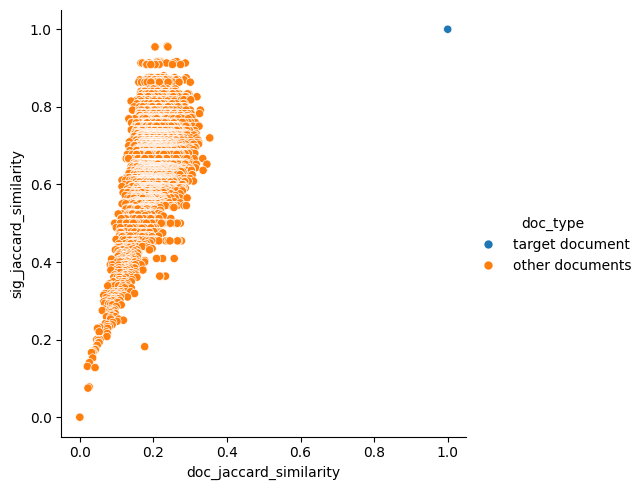

In [12]:
optimal_perm_num = int(minhash_fine_turn_result.sort_values(by=['correlation'],ascending=False).head(1)['num_perm'].values)
minhash_result = permutation_dict[optimal_perm_num]
# minhash_result.plot(x='sig_jaccard_similarity', y='doc_jaccard_similarity', style='o')
sns.relplot(data=minhash_result,x='doc_jaccard_similarity', y='sig_jaccard_similarity', hue='doc_type')

In [13]:
minhash_result[['doc_num','sig_jaccard_similarity','abstract_summary','doc_type']].head(10)

,doc_num,sig_jaccard_similarity,abstract_summary,doc_type
0,0,1.000000,Coronavirus disease 2019 caused by the severe ...,target document
3675,3675,0.956522,Microvascular dysfunction plays a fundamental ...,other documents
388,388,0.954545,Conclusion: An evidence-based sustainable and ...,other documents
4752,4752,0.954545,SARS-CoV-2 (CoV) is the etiological agent of t...,other documents
7173,7173,0.954545,Infectious diseases pose major socioeconomic a...,other documents
3230,3230,0.916667,BACKGROUND: The prospective DIabetes and CATar...,other documents
5189,5189,0.916667,Stem cells from human exfoliated deciduous tee...,other documents
5925,5925,0.916667,The photocatalytic properties of titanium diox...,other documents
6996,6996,0.916667,Background: The mortality rate from acute resp...,other documents
7818,7818,0.913043,Insulin represents a mainstay of glucose-lower...,other documents


## SimHash

Using TF-IDF as document feature. Create a signature matrix using SimHash.
Compare the signature Hamming distance with the document cosine similarity.

In [14]:
tfidf_feature_list = list(tfidf_vectorizer.get_feature_names_out())

feature_hash_md5 = get_feature_hash(tfidf_feature_list,'md5')
finger_print_list_md5 = get_finger_print_list(X_tfidf,feature_hash_md5)

feature_hash_sha1 = get_feature_hash(tfidf_feature_list,'sha1')
finger_print_list_sha1 = get_finger_print_list(X_tfidf,feature_hash_sha1)

In [15]:
# Check Performance
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

md5 = check_simhash_similarity(finger_print_list_md5,target_doc_num)
md5 = tfidf_result.merge(md5,how='outer',on='doc_num')
md5 = md5.sort_values(by=['sig_hamming_distance'],ascending=True)

sha1 = check_simhash_similarity(finger_print_list_sha1,target_doc_num)
sha1 = tfidf_result.merge(sha1,how='outer',on='doc_num')
sha1 = sha1.sort_values(by=['sig_hamming_distance'],ascending=True)

if pearsonr(md5['doc_cosine_similarity'],md5['sig_hamming_distance']).statistic < pearsonr(sha1['doc_cosine_similarity'],sha1['sig_hamming_distance']).statistic:
    simhash_result = md5
else:
    simhash_result = sha1

PearsonRResult(statistic=-0.7730891301719717, pvalue=0.0)


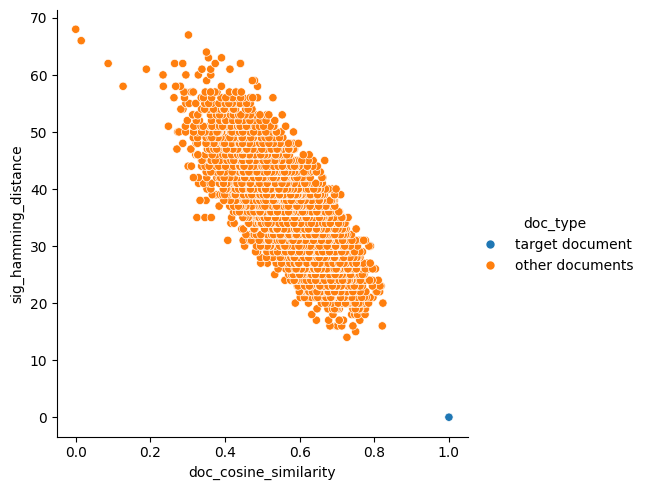

In [16]:
print(pearsonr(md5['doc_cosine_similarity'],md5['sig_hamming_distance']))
# md5.plot(x='doc_cosine_similarity', y='sig_hamming_distance', style='o')
sns.relplot(data=md5,x='doc_cosine_similarity', y='sig_hamming_distance', hue='doc_type')

PearsonRResult(statistic=-0.7889262932924689, pvalue=0.0)


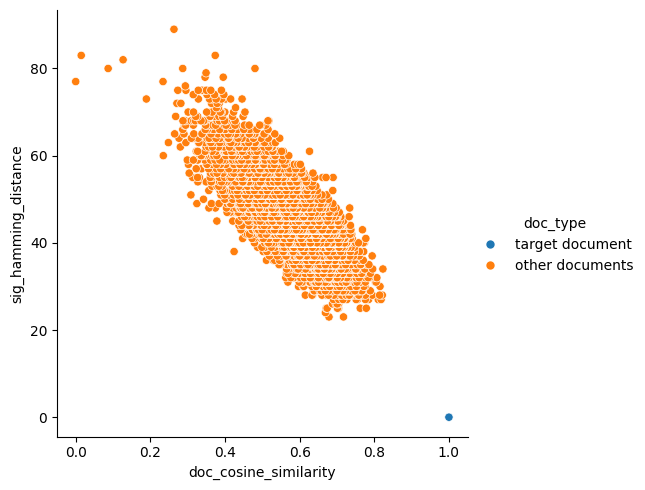

In [17]:
print(pearsonr(sha1['doc_cosine_similarity'],sha1['sig_hamming_distance']))
# sha1.plot(x='doc_cosine_similarity', y='sig_hamming_distance', style='o')
sns.relplot(data=sha1,x='doc_cosine_similarity', y='sig_hamming_distance', hue='doc_type')

In [18]:
simhash_result[['doc_num','sig_hamming_distance','abstract_summary','doc_type']].head(10)

,doc_num,sig_hamming_distance,abstract_summary,doc_type
0,0,0,Coronavirus disease 2019 caused by the severe ...,target document
4797,4797,23,Although mobility shapes the material landscap...,other documents
7155,7155,23,Background. Traditional Chinese medicine Yinhu...,other documents
4220,4220,24,"solutions emerge (Hong and Page, 2004; Valenti...",other documents
4538,4538,25,"Public health events, as the common concern fa...",other documents
4208,4208,25,Sepsis and COVID-19 are two clinical condition...,other documents
7669,7669,25,Background: To evaluate and determine the prot...,other documents
2158,2158,25,Debates about emerging infectious diseases oft...,other documents
7543,7543,25,The first case records of COVID-19 in the worl...,other documents
5420,5420,25,In the context of sports-based interventions f...,other documents


## Doc2Vec

Word2Vec also need to consider token position for word embeding. Use the original text instead of the processed text for vectorization.

In [19]:
# Use pretrained model to tokenize the documents.
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
# Use abstract summary instaed of body_test since it has less tokens.
original_docs = list(df['abstract_summary'])
tagged_docs = tag_documents(tokenizer,original_docs)

In [21]:
model = Doc2Vec()
model.build_vocab(tagged_docs)
model.train(tagged_docs,total_examples=model.corpus_count,epochs=20)

doc2vec_result = get_doc2vec_result(model,tokenizer,original_docs,target_doc_num,df)
doc2vec_result[['doc_num','doc2vec_similarity','abstract_summary','doc_type']].head(10)

,doc_num,doc2vec_similarity,abstract_summary,doc_type
0,0,0.912515,Coronavirus disease 2019 caused by the severe ...,target document
1,4980,0.653773,"The newly emerged coronavirus, which was desig...",other documents
2,1234,0.627090,"Salvia miltiorrhiza Bunge, known as Danshen in...",other documents
3,5718,0.609747,"Citation: Nefedova, E.; Koptev, V.; Bobikova, ...",other documents
4,6928,0.609233,"As a crucial organ, the lung is exposed to var...",other documents
5,7042,0.603435,"Zika fever, a mosquito-borne infectious diseas...",other documents
6,1802,0.601862,"Background: Thalassaemia, a hereditary haemogl...",other documents
7,144,0.597793,HIV-related diarrhoea is an important cause of...,other documents
8,5791,0.593548,Pancreatic-related disorders such as pancreati...,other documents
9,6505,0.591503,"Since Dec. 2019, an outbreak of pneumonia case...",other documents


## Comparsion

Comparing the performance of different document similarity search methods with the cosine similarity of document with TF-IDF word embeding.

In [22]:
combine_result = get_combined_similarity_result(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_df = get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_diff_df = get_performance_rank_diff(rank_df)

In [23]:
rank_diff_df

,doc_num,tfidf_doc_cosine,count_doc_l2_norm,clip_doc_l1_norm,minhash_jaccard,simhash_hamming,doc2vec
0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,3412.0,-2195.0,-69.5,-369.0,2823.5,-2353.0
2,2,920.0,4099.0,3014.5,2504.5,-879.5,2500.0
3,3,1609.0,550.0,1594.0,1618.0,569.5,-1509.0
4,4,1473.0,840.5,-825.0,5595.5,-4.0,599.0
...,...,...,...,...,...,...,...
8036,8036,6282.0,-5499.0,-4801.0,933.0,-984.0,-1664.0
8037,8037,394.0,3431.0,3813.5,232.0,-184.0,548.0
8038,8038,4453.0,1679.0,1217.0,-443.0,-2274.5,-439.0
8039,8039,3205.0,-1405.0,940.0,-2882.5,-1736.0,486.0


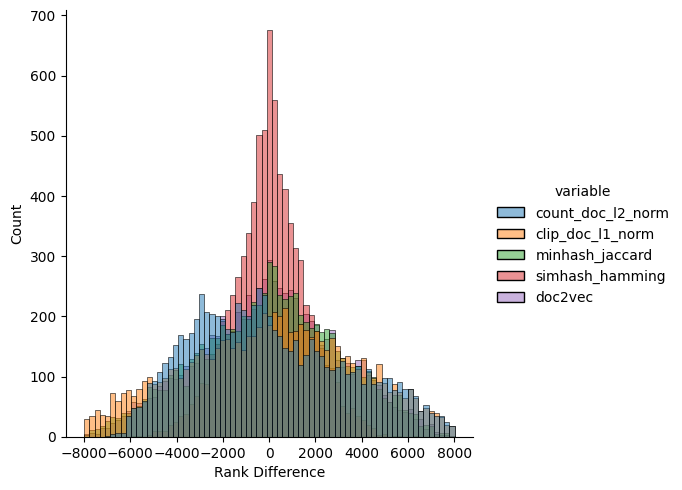

In [24]:
plot_df = rank_diff_df.drop(columns=['doc_num','tfidf_doc_cosine']).melt().rename(columns={'value':'Rank Difference'})
sns.displot(plot_df, x='Rank Difference', hue='variable')

In [25]:
var_rank_diff = rank_diff_df.drop(columns=['doc_num','tfidf_doc_cosine']).var(axis=0)
var_rank_diff = var_rank_diff.reset_index().rename(columns={'index':'metric',0:'variance'})
var_rank_diff = var_rank_diff.sort_values(by=['variance'],ascending=True)
var_rank_diff

,metric,variance
3,simhash_hamming,2.538154e+06
4,doc2vec,8.845181e+06
2,minhash_jaccard,9.275360e+06
0,count_doc_l2_norm,1.094450e+07
1,clip_doc_l1_norm,1.299531e+07


# Association Analysis

In [ ]:
from association_analysis import *

In [ ]:
# Input
# Can be word that is not in feature but in model
target_word_list = ['vaccine', 'pandemic', 'respiratory']

In [ ]:
if len(target_word_list) > 0:
    token_list = list(count_vectorizer.get_feature_names_out())
    index_dict = get_target_document_index(X_count,token_list,target_word_list)
    interested_list = list()
    for key in index_dict:
        interested_list += index_dict[key]
    print(len(interested_list))
    df = df.iloc[interested_list]

## Association Rule (LDA)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Create Dictionary
id2word = corpora.Dictionary(df['all_text_list'])
# Create Corpus
texts = df['all_text_list']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Set number of topics
num_topics = 4
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['all_text_list'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Prepare Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                    width=4000,
                    height=2000,
                    max_words=10,
                    prefer_horizontal=1.0,
                    background_color='whitesmoke'
                )

topics = lda_model.show_topics(formatted=False)
# Print the keywords for each topic
pprint(lda_model.print_topics())
print(lda_model.top_topics)

fig, axes = plt.subplots(1, num_topics, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(cloud)
    plt.gca().set_title(str(start_year) + '-' + str(end_year) + ': Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.imshow(cloud, interpolation='bilinear')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
vis

## Prepare for Association Mining 

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder

min_support = 0.6
mine_col = 'all_text_list'

# Pre-processing
te = TransactionEncoder()
te_ary = te.fit (df['all_text_list']).transform(df['all_text_list'])
df_processd_text = pd.DataFrame (te_ary, columns=te.columns_)
print(df_processd_text)

In [ ]:
def find_association_rules(frq_items):
    # Collecting the inferred rules in a dataframe 
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x)) 
    rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x)) 
    rules = rules.sort_values(['lift', 'antecedent_len', 'consequents_len', 'confidence'], ascending=[False, False, False, False]) 
    return rules 

def draw_graph(rules, rules_to_show, topics, title):
     import networkx as nx  
     G1 = nx.DiGraph()
     color_map=[]
     strs = []
     for i in range(len(topics)):
         strs += dict(topics[i][1])
     
     for z in range(rules_to_show):
          rand_index = np.random.randint(0, len(rules) - 1)
          for a in rules.iloc[rand_index]['antecedents']:
               G1.add_nodes_from([a])
               G1.add_edge(a, rules.iloc[rand_index]['antecedents'], weight = 2)
       
          for c in rules.iloc[i]['consequents']:
               G1.add_nodes_from([c])
               G1.add_edge(rules.iloc[rand_index]['consequents'], c, weight=2)

          for node in G1:
               found_a_string = False
               for item in strs:
                    if node==item:
                         found_a_string = True
       
                    if found_a_string:
                         color_map.append('yellow')
                    else:
                         color_map.append('green')       


     edges = G1.edges()
     pos = nx.spring_layout(G1, k=16, scale=1)
     plt.figure(figsize=(13,7))
     nx.draw_networkx(G1, pos, arrows=True, with_labels=True, node_color='lightblue', node_size=2500)            
     plt.title(title)
     plt.show()

In [ ]:
def draw_catgraph(rules, rules_to_show, topics, title):
    N = 50
    x = rules["antecedents"]
    y = rules["consequents"]

    colors = np.random.rand(N)
    area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
    plt.figure(figsize=(13,7))
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.title(title)
    plt.show()

## Association Rule (FP Growth)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth

frq_items_fp = fpgrowth(df_processd_text, min_support=min_support, use_colnames=True)
print(frq_items_fp.head())
rules_fp = find_association_rules(frq_items_fp)
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_fp) > 0:
    #draw_catgraph (rules_fp, 10, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_fp, 5, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')

## Association Rule (Apriori Algorithm)

In [ ]:
# Building the model 
frq_items_ap = apriori(df_processd_text, min_support = min_support, use_colnames = True) 
print(frq_items_ap.head())
rules_ap = find_association_rules(frq_items_ap)
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_ap) > 0:
    #draw_catgraph (rules_ap, 10, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_ap, 5, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')

# Clustering Analysis